In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


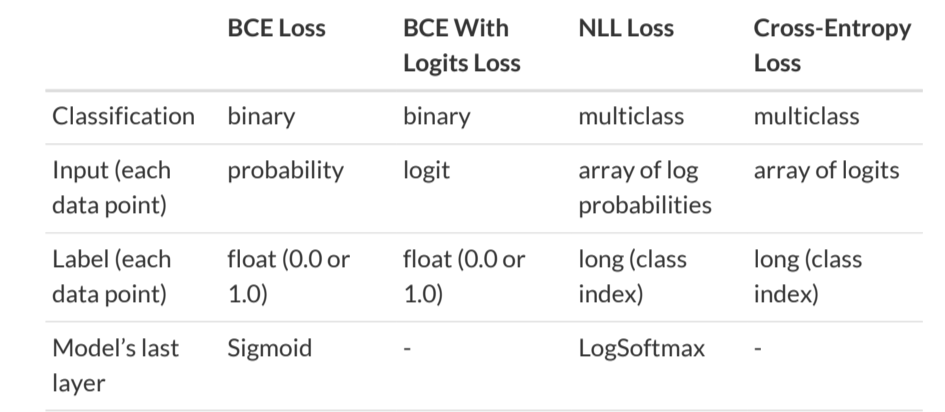

In [2]:
X,y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13)


In [3]:
# 转换为tensor
X_train_tensor = torch.as_tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.as_tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.as_tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.int64)
# 数据集
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [4]:
# 定义模型
class Classification(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [5]:
# mini-batch training
def mini_batch_train(model, train_loader, optimizer, loss_fn):
    mini_batch_losses = []
    for x_batch, y_batch in train_loader:
        model.train()
        # step 1 前向计算预测值
        yhat = model(x_batch)
        # step 2 计算损失
        mini_batch_loss = loss_fn(yhat, y_batch)
        # step 3 计算梯度
        mini_batch_loss.backward()
        # step 4 更新参数
        optimizer.step()
        # 清空梯度
        optimizer.zero_grad()
        # 记录损失
        mini_batch_losses.append(mini_batch_loss.item())
    
    return np.mean(mini_batch_losses)


In [6]:
# 测试
def mini_batch_val(model, test_loader, optimizer, loss_fn):
    mini_batch_losses = []
    for x_batch, y_batch in test_loader:
        model.eval()
        # 置为验证状态
        model.eval()
        # Step 1 - 前向计算预测值
        yhat = model(x_batch)
        # Step 2 - 计算损失
        mini_batch_loss = loss_fn(yhat, y_batch)
        mini_batch_losses.append(mini_batch_loss.item())
    
    return np.mean(mini_batch_losses)


In [7]:
# 训练
def train(model, train_loader, test_loader, optimizer, loss_fn, epochs):
    # 指定随机数种子，可以再现数据
    np.random.seed(23)
    torch.manual_seed(23)

    # 循环轮数计数
    total_epochs = 0
    # 记录训练和验证损失
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # 训练
        model.train()
        total_epochs += 1
        train_loss = mini_batch_train(model, train_loader, optimizer, loss_fn)
        train_losses.append(train_loss)
        # 验证
        with torch.no_grad():
            val_loss = mini_batch_val(model, test_loader, optimizer, loss_fn)
            val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    
    return train_losses, val_losses

In [8]:
model = Classification()
loss = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 100
train_losses, val_losses = train(model, train_loader, test_loader, optimizer, loss, epochs)


Epoch 1/100, train_loss: 1.1348, val_loss: 1.1186
Epoch 2/100, train_loss: 1.0922, val_loss: 1.0762
Epoch 3/100, train_loss: 1.0572, val_loss: 1.0395
Epoch 4/100, train_loss: 1.0292, val_loss: 1.0183
Epoch 5/100, train_loss: 1.0055, val_loss: 0.9947
Epoch 6/100, train_loss: 0.9770, val_loss: 0.9615
Epoch 7/100, train_loss: 0.9424, val_loss: 0.9171
Epoch 8/100, train_loss: 0.9073, val_loss: 0.8743
Epoch 9/100, train_loss: 0.8681, val_loss: 0.8334
Epoch 10/100, train_loss: 0.8233, val_loss: 0.7874
Epoch 11/100, train_loss: 0.7742, val_loss: 0.7388
Epoch 12/100, train_loss: 0.7248, val_loss: 0.7039
Epoch 13/100, train_loss: 0.6850, val_loss: 0.6569
Epoch 14/100, train_loss: 0.6349, val_loss: 0.6180
Epoch 15/100, train_loss: 0.6051, val_loss: 0.5787
Epoch 16/100, train_loss: 0.5740, val_loss: 0.5501
Epoch 17/100, train_loss: 0.5366, val_loss: 0.5307
Epoch 18/100, train_loss: 0.5201, val_loss: 0.5036
Epoch 19/100, train_loss: 0.4851, val_loss: 0.4833
Epoch 20/100, train_loss: 0.4829, val_lo

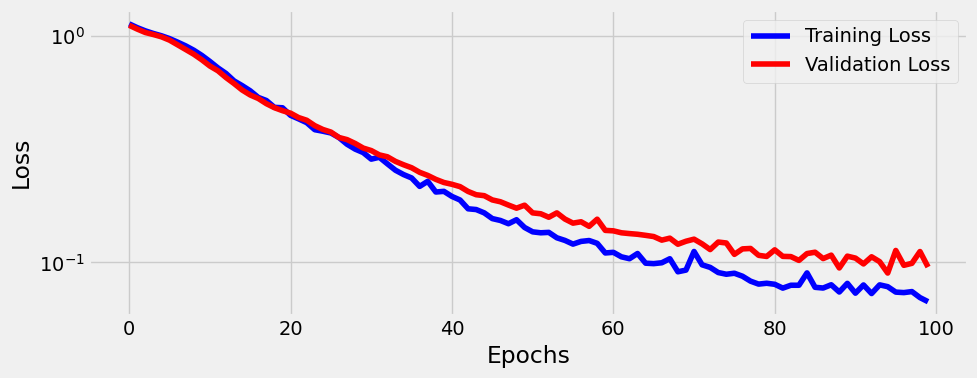

In [9]:
plt.style.use('fivethirtyeight')
def plot_losses():
    fig = plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Training Loss', c='b')
    plt.plot(val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

fig=plot_losses()

In [10]:
def correct(model, test_loader):
        predicteds = []
        ylabels = []
        for x, y in test_loader:
                model.eval()
                yhat = model(x)
                predicted = torch.argmax(yhat, dim=1).detach().numpy()
                predicteds.extend(predicted)
                ylabels.extend(y.detach().numpy())
        return predicteds, ylabels
        

In [11]:
predicteds, ylabels = correct(model, test_loader)

In [12]:
print(predicteds)
print(ylabels)

[1, 1, 0, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 1, 0, 1, 0, 0, 2, 1, 2, 0, 2, 1, 2]
[1, 1, 0, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 0, 2, 0, 2, 2, 1, 0, 1, 0, 0, 2, 1, 2, 0, 2, 1, 2]


In [13]:
sum = 0
for i in range(len(predicteds)):
        if predicteds[i] == ylabels[i]:
            sum += 1

print(sum/len(predicteds))

1.0
